In [52]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/data/wadld/")
import os
import cv2
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from utils import (
    utils,
    draw_wad,
    wadreader,
    data_transformation
)
from utils.utils import duplicate_linedefs
import sklearn.cluster as cluster
import seaborn as sns
from utils.rendering import draw_traversable_space, draw_linedefs
from utils.wadreader import decode_wad
from utils.io_utils import get_wad_paths
from ml.feature_extraction import feature_mat

sns.reset_orig()  # get default matplotlib styles back

ddir = "/data/wadld/data/dataset/"
df_filename = "all_wads.pkl"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be remo

In [53]:
wad_dir = "pagbspd3_0/"
filename = "pagbspd3.wad"
wad_path = os.path.join(ddir, wad_dir, filename)
vertices, linedefs, sidedefs, sectors = decode_wad(wad_path)
new_linedefs = duplicate_linedefs(linedefs)
walls_only = [line for line in new_linedefs if line.impassable()]
new_fmat = feature_mat(vertices, new_linedefs, sidedefs, sectors)
walls_fmat = feature_mat(vertices, walls_only, sidedefs, sectors)
print("duplicated features: {}".format(new_fmat.shape))
print("impassable only features: {}".format(walls_fmat.shape))

num_sides=2813
duplicated features: (4261, 160)
impassable only features: (1395, 160)


In [54]:
image = draw_linedefs(vertices, new_linedefs, color=(255, 0, 0))  # draw_traversable_space(vertices, new_linedefs, debug=True)
image_walls = draw_linedefs(vertices, walls_only, color=(255, 0, 0))
# image_walls = draw_traversable_space(vertices, walls_only, debug=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'impassable linedefs')

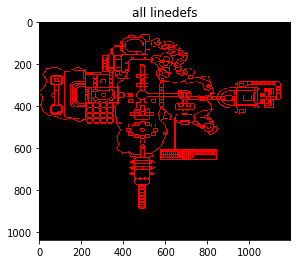

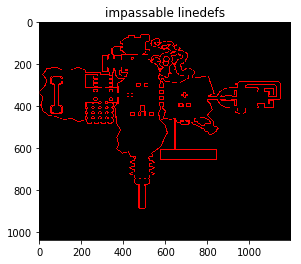

In [55]:
image = cv2.resize(image, (int(image.shape[0]/8),int(image.shape[1]/8)))
image_walls = cv2.resize(image_walls, (int(image_walls.shape[0]/8),int(image_walls.shape[1]/8)))
plt.imshow(image)
plt.title("all linedefs")
plt.figure()
plt.imshow(image_walls)
plt.title("impassable linedefs")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


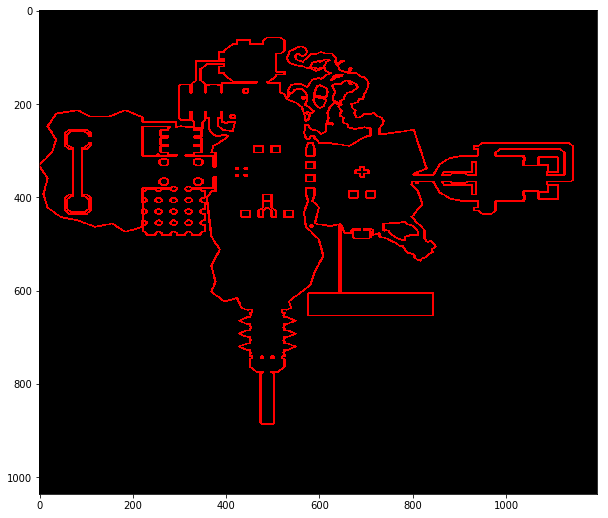

In [57]:
X = walls_fmat
image_walls = draw_linedefs(vertices, walls_only, color=(255, 0, 0))
image_walls = cv2.resize(image_walls, (int(image_walls.shape[0]/8),int(image_walls.shape[1]/8)))
plt.figure(figsize=(10, 10))
plt.imshow(image_walls)

In [80]:
def get_clusters(X, n_clusters):
    km = cluster.KMeans(n_clusters=n_clusters).fit(X)
    return km.labels_, km

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


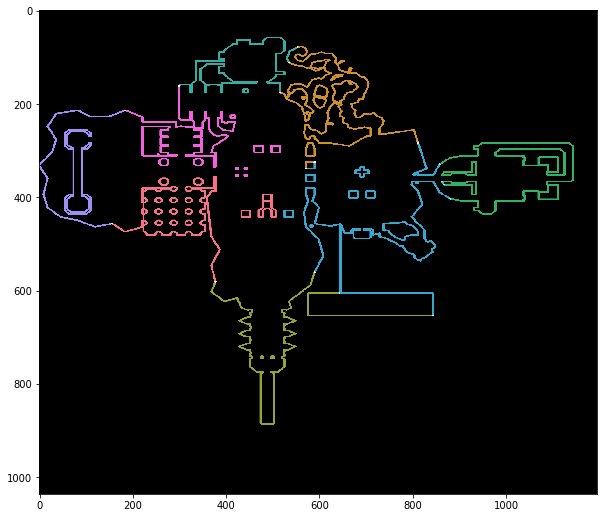

In [81]:
N = 8
X = walls_fmat
wall_labels, km = get_clusters(X, N)
colors = utils.get_color_palette(N)
plt.figure(figsize=(10, 10))
full_image = None
for c in range(N):
    color = tuple([int(colors[c][i] * 255) for i in range(3)])
    cluster_linedefs = [walls_only[i] for i in range(len(walls_only)) if wall_labels[i] == c]
    cluster_image = draw_linedefs(vertices, cluster_linedefs, color=color)
    cluster_image = cv2.resize(cluster_image, (int(cluster_image.shape[0]/8),int(cluster_image.shape[1]/8)))
    if full_image is None:
        full_image = cluster_image
    else:
        full_image += cluster_image
plt.imshow(full_image / 255.0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


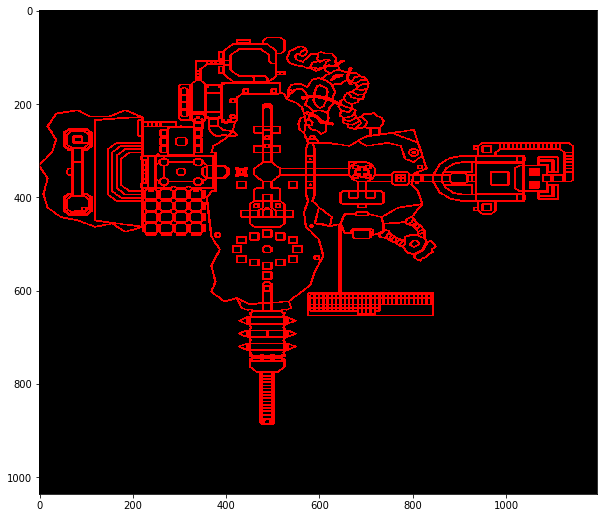

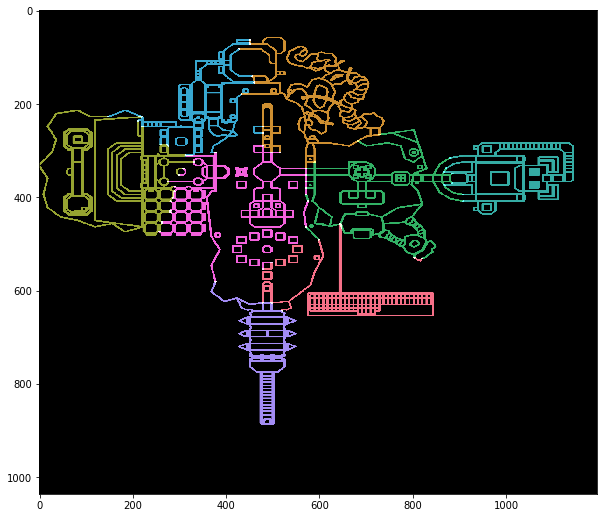

In [82]:
X = new_fmat
image_walls = draw_linedefs(vertices, new_linedefs, color=(255, 0, 0))
image_walls = cv2.resize(image_walls, (int(image_walls.shape[0]/8),int(image_walls.shape[1]/8)))
plt.figure(figsize=(10, 10))
plt.imshow(image_walls)

N = 8
labels, km = get_clusters(X, N)
colors = utils.get_color_palette(N)
plt.figure(figsize=(10, 10))
full_image = None
for c in range(N):
    color = tuple([int(colors[c][i] * 255) for i in range(3)])
    cluster_linedefs = [new_linedefs[i] for i in range(len(new_linedefs)) if labels[i] == c]
    cluster_image = draw_linedefs(vertices, cluster_linedefs, color=color)
    cluster_image = cv2.resize(cluster_image, (int(cluster_image.shape[0]/8),int(cluster_image.shape[1]/8)))
    if full_image is None:
        full_image = cluster_image
    else:
        full_image += cluster_image
plt.imshow(full_image / 255.0)

In [88]:
from ml.clustering import cluster_and_plot
# def cluster_and_plot(verts, lines, sides, secs, N, clustering_=cluster.KMeans, feature_indices=None, plot=False):
#     ''' Cluster linedefs using the features returned by ml.feature_mat, after which the clustered linedefs are drawn
#     @param verts (utils.wadreader.Vertex list)
#     @param lines (utils.linedef.Linedef list): A list of one sided line defs.
#     @param sides (utils.sidedef.Sidedef list): List of sidedefs which can be indexed into by corresponding linedef.
#     @param secs (utils.sector.Sector list): List of sectors
#     @param N (int): Number of clusters to create.
#     @param clustering_ (class): sklearn-like clustering estimator class
#     @param feature_indices (list): indices of feature_mat (along dim=1) to use as features
#     @param plot (bool): If True, then clusters are plotted.
    
#     @return estimator (instance of clustering_): Instance of clustering_
#     @return labels (array-like): Cluster labels for each line
#     '''
#     X = feature_mat(verts, lines, sides, secs)
#     if feature_indices is not None:
#         X = X[:, feature_indices]
#     if (len(lines) != X.shape[0]):
#         raise RuntimeError("linedefs must be one sided. Please use the duplicate_linedefs function first.")
#     estimator = clustering_(n_clusters=N).fit(X)
#     labels = estimator.labels_

#     if plot:
#         colors = utils.get_color_palette(N)
#         plt.figure(figsize=(10, 10))
#         full_image = None
#         for c in range(N):
#             color = tuple([int(colors[c][i] * 255) for i in range(3)])
#             cluster_linedefs = [lines[i] for i in range(len(lines)) if labels[i] == c]
#             cluster_image = draw_linedefs(verts, cluster_linedefs, color=color)
#             cluster_image = cv2.resize(cluster_image, (int(cluster_image.shape[0]/8),int(cluster_image.shape[1]/8)))
#             if full_image is None:
#                 full_image = cluster_image
#             else:
#                 full_image += cluster_image
#         plt.imshow(full_image / 255.0)
#     return estimator, labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


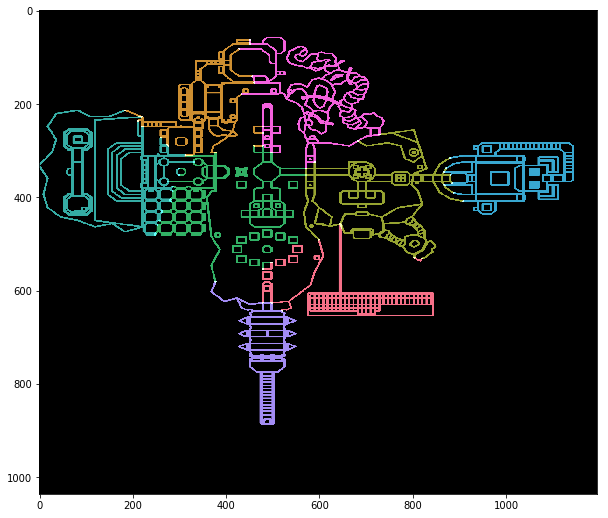

In [94]:
estimator, labels = cluster_and_plot(
    vertices, 
    [line for line in new_linedefs],# if line.impassable()], 
    sidedefs, 
    sectors, 
    8, 
    plot=True
)